In [2]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer, KNNImputer

## Defining the bucket
s3= boto3.resource('s3')
bucket_name= 'omar-vargas-bucket'
bucket= s3.Bucket(bucket_name)

## Defining the csv file
file_key= 'train_data.csv'

bucket_object= bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
train_data = pd.read_csv(file_content_stream)
train_data.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [3]:
## Reporting number of observations by product_code
train_data['product_code'].value_counts()

C    5765
E    5343
B    5250
D    5112
A    5100
Name: product_code, dtype: int64

<AxesSubplot: xlabel='measurement_10', ylabel='Count'>

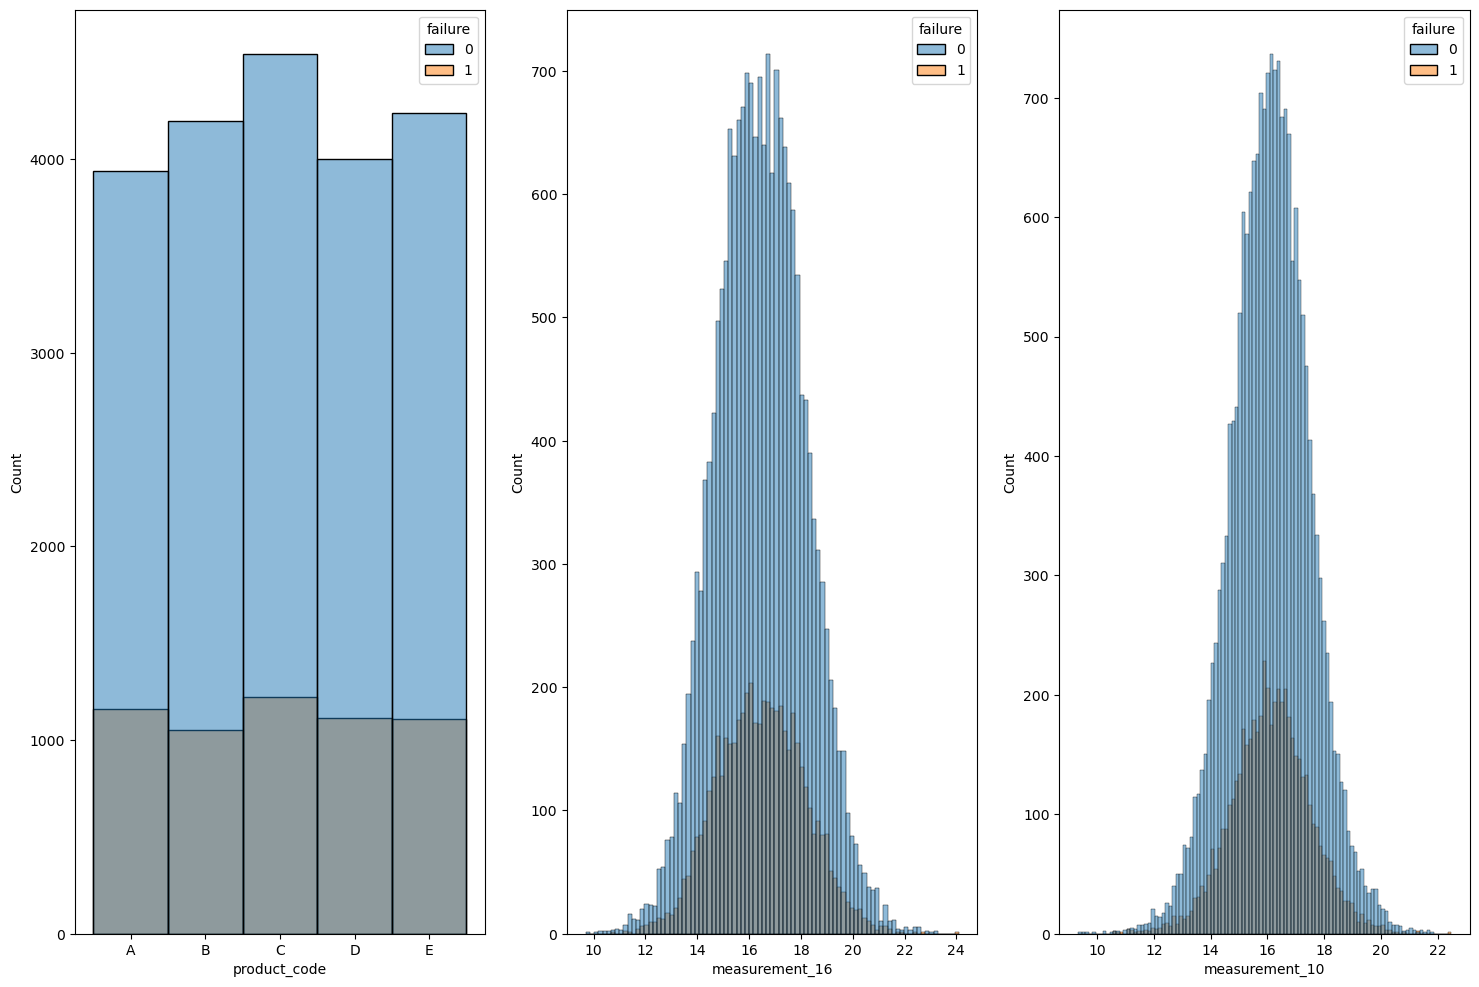

In [5]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize = (18, 12))
sns.histplot(ax = axes[0], x = 'product_code', hue = 'failure', fill = True, data = train_data)
sns.histplot(ax = axes[1], x = 'measurement_16', hue = 'failure', fill = True, data = train_data)
sns.histplot(ax = axes[2], x = 'measurement_10', hue = 'failure', fill = True, data = train_data)

In [ ]:
## Fig 1: As you can see the data is distributed almost evenly but there are a lot less failures then not. 
## Fig 2&3: Here you can see two of the measurments which have a normalish shaped distribution for both 0 and 1 (failure).

In [6]:
#Defining input and target variables
X = train_data.drop(columns=['failure', 'product_code', 'attribute_0', 'attribute_1'], axis=1)
Y = train_data['failure']

## Splitting the data
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size = .2, stratify = Y)

In [7]:
## Defining the imputer
imputer = KNNImputer(n_neighbors = 5,  weights = 'distance').fit(X_train)

## Imputing thr missing values
X_train_imp = pd.DataFrame(imputer.transform(X_train), columns = X_train.columns)
X_test_imp = pd.DataFrame(imputer.transform(X_test), columns = X_test.columns)

Random Forest

In [8]:
RF_md = RandomForestClassifier(n_estimators = 500, max_depth = 5).fit(X_train_imp, Y_train)

## Predicting on the test
RF_pred = RF_md.predict_proba(X_test_imp)[:,1]

## roc_auc_score
RF_auc = roc_auc_score(Y_test, RF_pred)

print('the area under the ROC curve for Random Forest model is', RF_auc)

the area under the ROC curve for Random Forest model is 0.5933894820555339


AdaBoost

In [9]:
Ada_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5), n_estimators = 500, learning_rate = 0.01).fit(X_train_imp, Y_train)

## Predicting on the test
Ada_pred = Ada_md.predict_proba(X_test_imp)[:,1]

## roc_auc_score
Ada_auc = roc_auc_score(Y_test, Ada_pred)

print('the area under the ROC curve for AdaBoost model is', Ada_auc)

the area under the ROC curve for AdaBoost model is 0.5537788287449872


In [ ]:
## Based on my results, I would use to the Random Forest model to predict failure.